<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b></b> <br>
Contact author: Eric Bellm<br>
Last verified to run: January 5, 2023<br>
LSST Science Piplines version: w_2023_01<br>
Container Size: Medium <br>

# DM-37378: test flag filtering with analysis_tools/apdb.py

after notebook from DM-35285: ApPipeWithFakes on HSC COSMOS, November 2022


* Used weekly `w_2022_46` with default convolution mode
* Working directory on USDF with bps logs, pipelines, etc. is `/sdf/group/rubin/user/elhoward/repo-main-logs/DM-35285`
* Templates are in `u/mrawls/DM-34711/templates`
* Final processing of HSC COSMOS is in `u/elhoward/DM-35285/hsc-output-collection`
* Postgres schema is `elhoward_dm35285_hsc_appipewithfakes`


In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import astropy.units as u
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler

from lsst.analysis.ap import apdb, CutoutPath

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from IPython.display import Image, display

## Define inputs

In [2]:
repo = '/repo/main'
butler = dafButler.Butler(repo)
instrument = 'HSC'
skymap = 'hsc_rings_v1'

dbType='postgres'
dbName='lsst-devl'

collections = 'u/elhoward/DM-35285/hsc-output-collection'
schema = 'elhoward_dm35285_hsc_appipewithfakes'
month = 'November'
year = '2022'

In [3]:

butler = lsst.daf.butler.Butler(repo, collections=collections)
apdbQuery = apdb.ApdbPostgresQuery(schema, butler=butler, instrument=instrument)


## Test flag filtering

In [4]:
with apdbQuery.connection as connection:
    print(pd.read_sql_query('select count("diaObjectId") from "DiaObject" where "validityEnd" is NULL', connection))

     count
0  2450334


In [5]:
with apdbQuery.connection as connection:
    print(pd.read_sql_query('select count("diaSourceId") from "DiaSource"', connection))

     count
0  5007735


In [6]:
sources = apdbQuery.load_sources(limit=100)
sources[['diaSourceId','flags']]

,diaSourceId,flags
0,136579960013410,25166188
1,136579960013411,98172972
2,136579960013412,114951100
3,136579960013413,47841612
4,136579960013414,25166156
...,...,...
95,136579960013505,109053224
96,136579960013506,40
97,136579960013507,109053224
98,136579960013508,109051944


In [7]:
sources_not_bad_flagged = apdbQuery.load_sources(exclude_flagged=True, limit=5)
sources_not_bad_flagged[['diaSourceId','flags']]

,diaSourceId,flags
0,136579960013416,25165824
1,136579960013429,0
2,136579960013448,25165824
3,136579960013466,0
4,136579960013491,75497472


## look at the unflagged cutouts

In [8]:
cutout_manager = CutoutPath("/sdf/group/rubin/u/parejko/scratch/cutouts", chunk_size=10000)

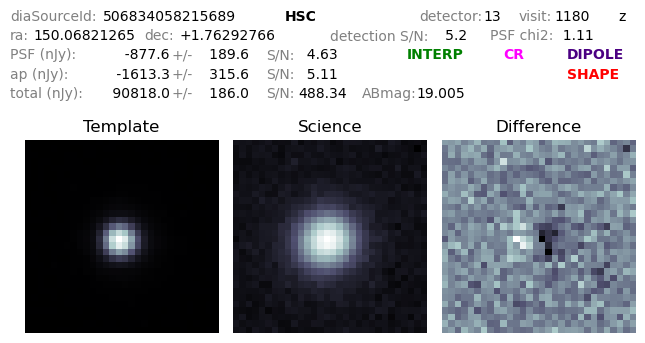

In [9]:
diaSourceId = 506834058215689
path = cutout_manager(diaSourceId)
display(Image(path))


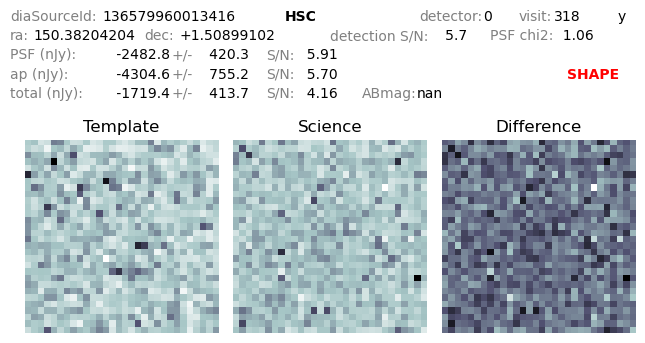

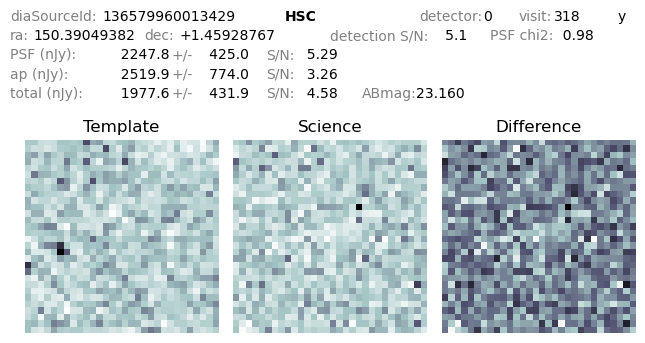

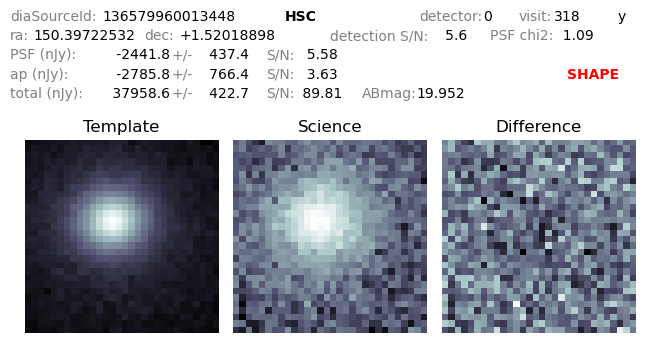

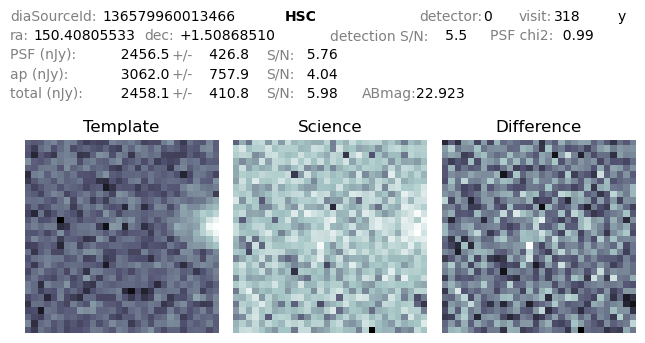

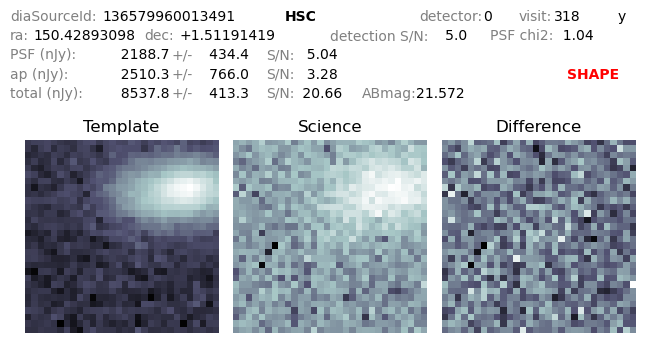

In [10]:
for idx, idi in sources_not_bad_flagged.iterrows():
    path = cutout_manager(idi["diaSourceId"])
    if os.path.exists(path):
        display(Image(path))

In [11]:
# show excluding a different flag.  we'll use the slot_Shape_flag since it's common, even though it excludes negative sources
exclude_flags = apdbQuery.diaSource_flags_exclude.copy()
exclude_flags.append('slot_Shape_flag')
apdbQuery.set_excluded_diaSource_flags(exclude_flags)
sources_no_dipoles = apdbQuery.load_sources(exclude_flagged=True, limit=5)
sources_no_dipoles[['diaSourceId','flags']]

,diaSourceId,flags
0,136579960013429,0
1,136579960013466,0
2,136579960013570,0
3,136579960013583,0
4,136579960013620,0


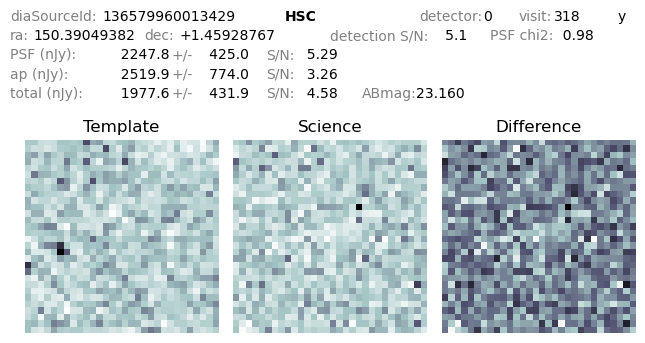

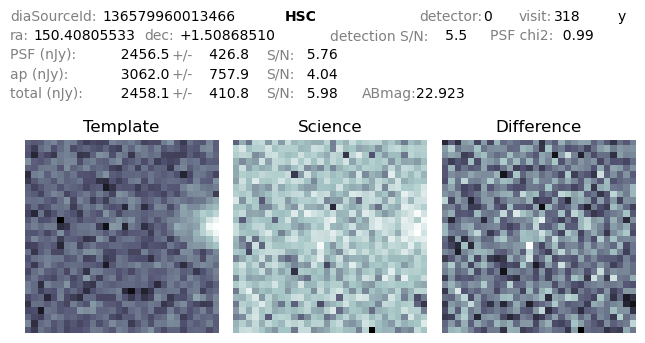

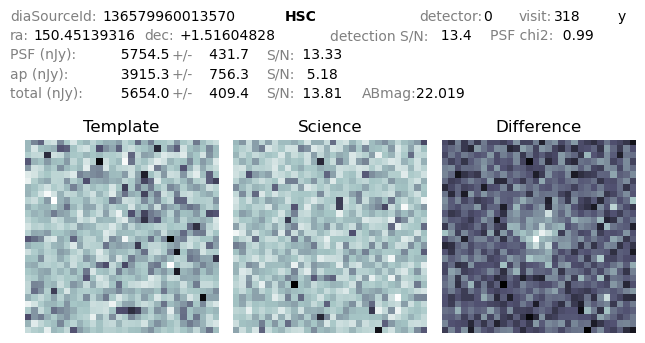

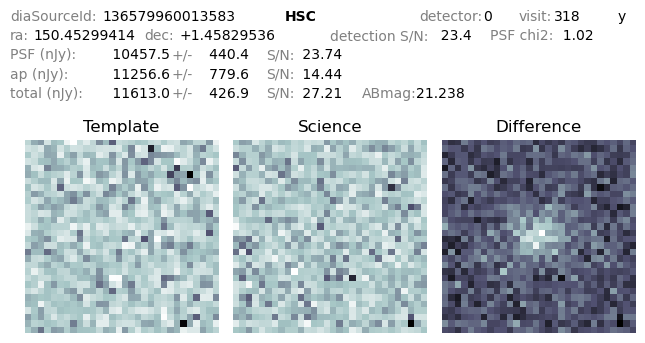

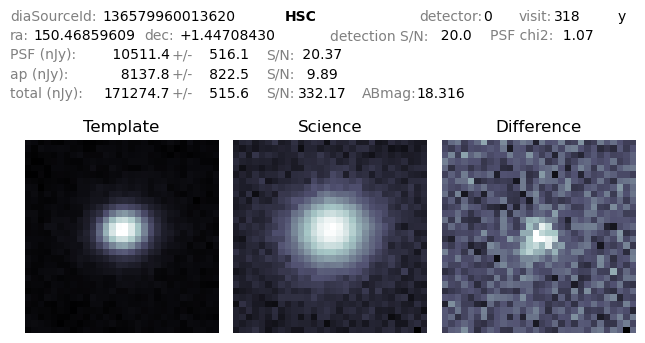

In [12]:
for idx, idi in sources_no_dipoles.iterrows():
    path = cutout_manager(idi["diaSourceId"])
    if os.path.exists(path):
        display(Image(path))